In [1]:
import os
import pandas as pd
import numpy as np
from scipy.signal import correlate
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

In [2]:
def load_data(directory="data"):
    data = {}
    required = {"open", "high", "low", "close", "volume", "turnover"}

    for file in os.listdir(directory):
        if not file.endswith(".csv"):
            continue

        symbol = file.replace("_15m_full.csv", "")
        path = os.path.join(directory, file)

        try:
            df = pd.read_csv(
                path,
                parse_dates=['timestamp'],
                date_format='%Y-%m-%d %H:%M:%S'
            ).set_index('timestamp')

            if required.issubset(df.columns):
                data[symbol] = df
        except Exception as e:
            print(f"Error loading {file}: {e}")

    return data

In [3]:
def compute_fft(df1, df2, column):
    x = df1[column].to_numpy()
    y = df2[column].to_numpy()
    min_len = min(len(x), len(y))
    x = x[:min_len]
    y = y[:min_len]
    
    normalized_x = (x - np.mean(x)) / np.std(x)
    normalized_y = (y - np.mean(y)) / np.std(y)
    
    fft_x = np.fft.fft(normalized_x)
    fft_y = np.fft.fft(normalized_y)
    
    cross_fft = (fft_x * np.conj(fft_y)) / min_len
    freqs = np.fft.fftfreq(min_len)
    
    return cross_fft, freqs

In [4]:
def fast_cross_correlation_series(df1, df2, column):
    x = df1[column].to_numpy()
    y = df2[column].to_numpy()
    min_len = min(len(x), len(y))
    x, y = x[:min_len], y[:min_len]
    x = (x - np.mean(x)) / np.std(x)
    y = (y - np.mean(y)) / np.std(y)
    corr = correlate(x, y, mode='full', method='fft')
    return corr / len(x)

In [5]:
def build_feature_correlation_matrices(data_dict, features, threshold=-2):
    symbols = list(data_dict.keys())
    matrices = {feat: pd.DataFrame(index=symbols, columns=symbols, dtype=object) for feat in features}

    for feat in features:
        for i, sym1 in enumerate(symbols):
            for j in range(i + 1, len(symbols)):
                sym2 = symbols[j]
                try:
                    # חישוב וקטור הקורלציה בין הסדרות
                    corr_vec = fast_cross_correlation_series(data_dict[sym1], data_dict[sym2], feat)
                    
                    # ביצוע FFT על וקטור הקורלציה
                    fft_corr = np.fft.fft(corr_vec)
                    mag = np.abs(fft_corr)
                    # מניעת log(0)
                    mag[mag == 0] = 1e-10
                    log_mag = np.log(mag)
                    
                    # קבלת התדרים
                    freqs = np.fft.fftfreq(len(corr_vec))
                    # התייחסות לתדרים חיוביים (מוציאים 0)
                    positive_mask = freqs > 0
                    pos_freqs = freqs[positive_mask]
                    pos_log_mag = log_mag[positive_mask]
                    
                    # חיפוש התדר הראשון שבו הלוג קטן או שווה ל-threshold
                    indices = np.where(pos_log_mag <= threshold)[0]
                    freq_value = pos_freqs[indices[0]] if len(indices) > 0 else None

                    matrices[feat].at[sym1, sym2] = freq_value
                    matrices[feat].at[sym2, sym1] = freq_value
                    
                except Exception as e:
                    matrices[feat].at[sym1, sym2] = None
                    matrices[feat].at[sym2, sym1] = None

        # הגדרת האלכסון לאפס
        for sym in symbols:
            matrices[feat].at[sym, sym] = 0

    return matrices

In [6]:
def build_fft_frequency_matrix(data_dict, features, threshold=-2):
    
    symbols = list(data_dict.keys())
    matrices = {feat: pd.DataFrame(index=symbols, columns=symbols, dtype=object)
                for feat in features}
    
    for feat in features:
        for i, sym1 in enumerate(symbols):
            for j in range(i + 1, len(symbols)):
                sym2 = symbols[j]
                try:
                    # חישוב ספקטרום פורייה צלבי באמצעות compute_fft
                    cross_fft, freqs = compute_fft(data_dict[sym1], data_dict[sym2], feat)
                    
                    # חישוב המגבלה של הספקטרום
                    mag = np.abs(cross_fft)
                    mag[mag == 0] = 1e-10  # מניעת log(0)
                    log_mag = np.log(mag)
                    
                    # סינון תדרים חיוביים (מתעלמים מ-0)
                    positive_mask = freqs > 0
                    pos_freqs = freqs[positive_mask]
                    pos_log_mag = log_mag[positive_mask]
                    
                    # איתור התדר הראשון שבו log(magnitude) קטן או שווה לסף
                    indices = np.where(pos_log_mag <= threshold)[0]
                    freq_value = pos_freqs[indices[0]] if len(indices) > 0 else None
                    
                    matrices[feat].at[sym1, sym2] = freq_value
                    matrices[feat].at[sym2, sym1] = freq_value
                    
                except Exception as e:
                    matrices[feat].at[sym1, sym2] = None
                    matrices[feat].at[sym2, sym1] = None
            
            matrices[feat].at[sym1, sym1] = 0
    return matrices

In [7]:
data_dict = load_data("data")

In [8]:
def plot_correlation_and_derivative_dual_axis(df1, df2, column="close", title=None):
    corr = fast_cross_correlation_series(df1, df2, column)
    sigma = 500
    filtered = gaussian_filter1d(corr, sigma=sigma)
    deriv = np.diff(filtered)

    lags = np.arange(-len(corr) // 2 + 1, len(corr) // 2 + 1)
    lags_deriv = lags[1:]

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_title(f"Correlation & Derivative - {title or column}")
    ax1.set_xlabel("Lag")
    ax1.set_ylabel("Correlation", color="blue")
    ax1.plot(lags, corr, label="Correlation", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.set_ylabel("Derivative", color="orange")
    ax2.plot(lags_deriv, deriv, label="Derivative", color="orange", alpha=0.7)
    ax2.tick_params(axis='y', labelcolor="orange")

    # סנכרון נקודת האפס בשני הצירים
    ymin1, ymax1 = ax1.get_ylim()
    ymin2, ymax2 = ax2.get_ylim()

    zero_ratio1 = abs(ymin1) / (ymax1 - ymin1)
    zero_ratio2 = abs(ymin2) / (ymax2 - ymin2)

    if zero_ratio1 > zero_ratio2:
        new_range = (ymax2 - ymin2) / (zero_ratio2 / zero_ratio1)
        center = 0
        ax2.set_ylim(center - new_range * zero_ratio1, center + new_range * (1 - zero_ratio1))
    else:
        new_range = (ymax1 - ymin1) / (zero_ratio1 / zero_ratio2)
        center = 0
        ax1.set_ylim(center - new_range * zero_ratio2, center + new_range * (1 - zero_ratio2))

    fig.tight_layout()
    plt.show()

In [9]:
def plot_filtered_cross_corr_fft(df1, df2, column, sigma=500):
    corr = fast_cross_correlation_series(df1, df2, column)
    corr -= np.mean(corr)  # הסרת תוחלת

    # סינון גאוסי במרחב הזמן
    filtered = gaussian_filter1d(corr, sigma=sigma)

    # FFT על הסיגנל המסונן
    fft_result = np.fft.fft(filtered)
    magnitude = np.abs(fft_result[:len(fft_result) // 2])
    log_magnitude = np.log10(magnitude + 1e-10)

    # פלוט
    plt.figure(figsize=(12, 6))
    plt.plot(log_magnitude)
    plt.title(f'Log FFT Magnitude of Gaussian-Filtered Cross-Correlation: {column}')
    plt.xlabel('Frequency bin')
    plt.ylabel('log10(Magnitude)')
    plt.grid(True)
    plt.show()


In [10]:
#plot_correlation_and_derivative_dual_axis(data_dict["BTCUSDT"], data_dict["LSKUSDT"], column="close", title="BTC vs ETH")

In [11]:
#plot_filtered_cross_corr_fft(data_dict["BTCUSDT"], data_dict["LSKUSDT"], column="close", sigma=75)

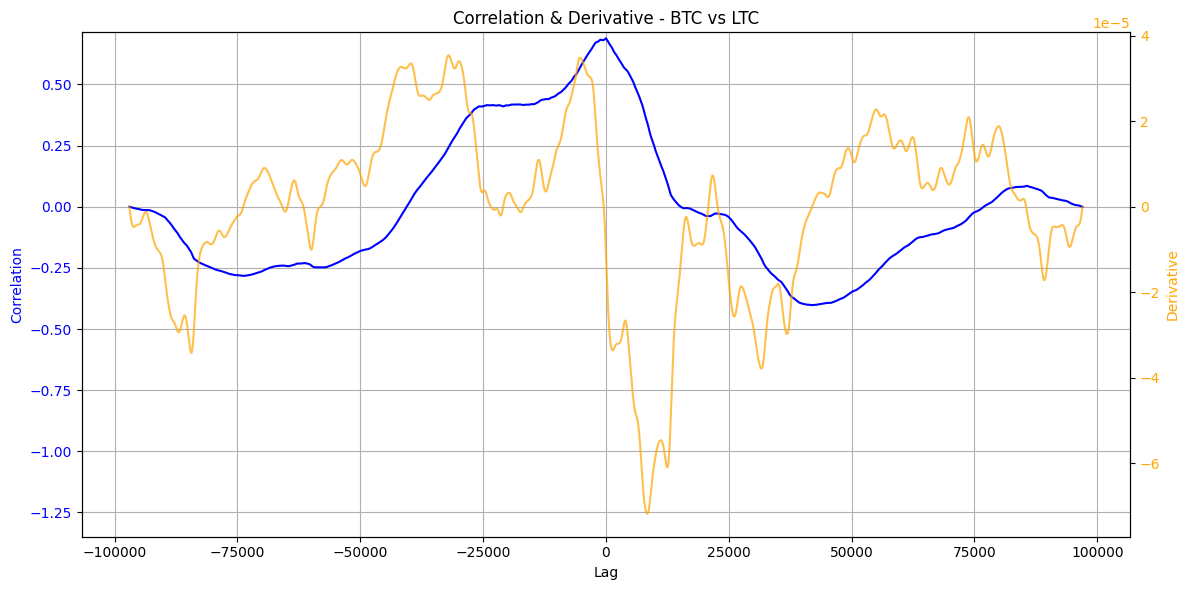

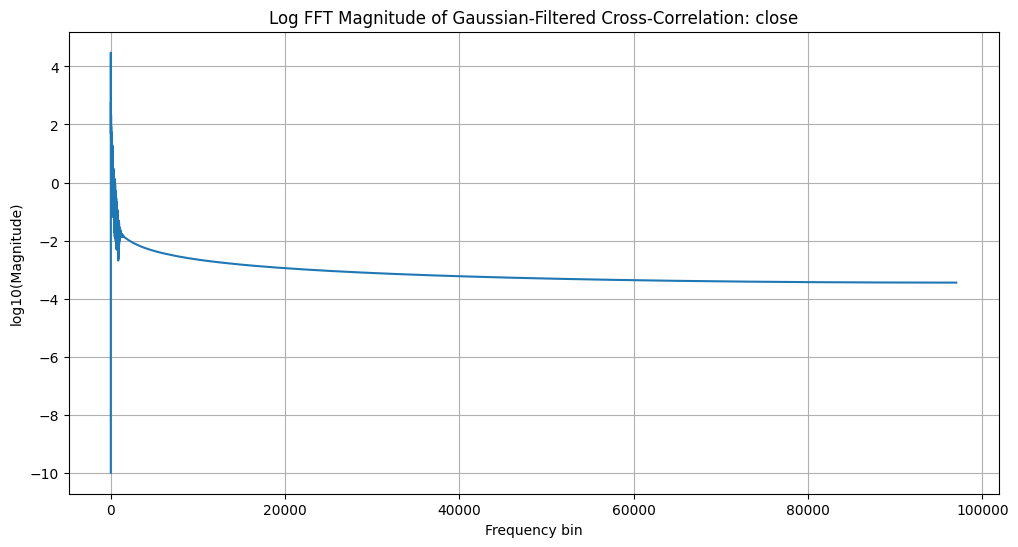

In [12]:
plot_correlation_and_derivative_dual_axis(data_dict["BTCUSDT"], data_dict["RSRUSDT"], column="close", title="BTC vs LTC")
plot_filtered_cross_corr_fft(data_dict["BTCUSDT"], data_dict["RSRUSDT"], column="close",sigma=75)

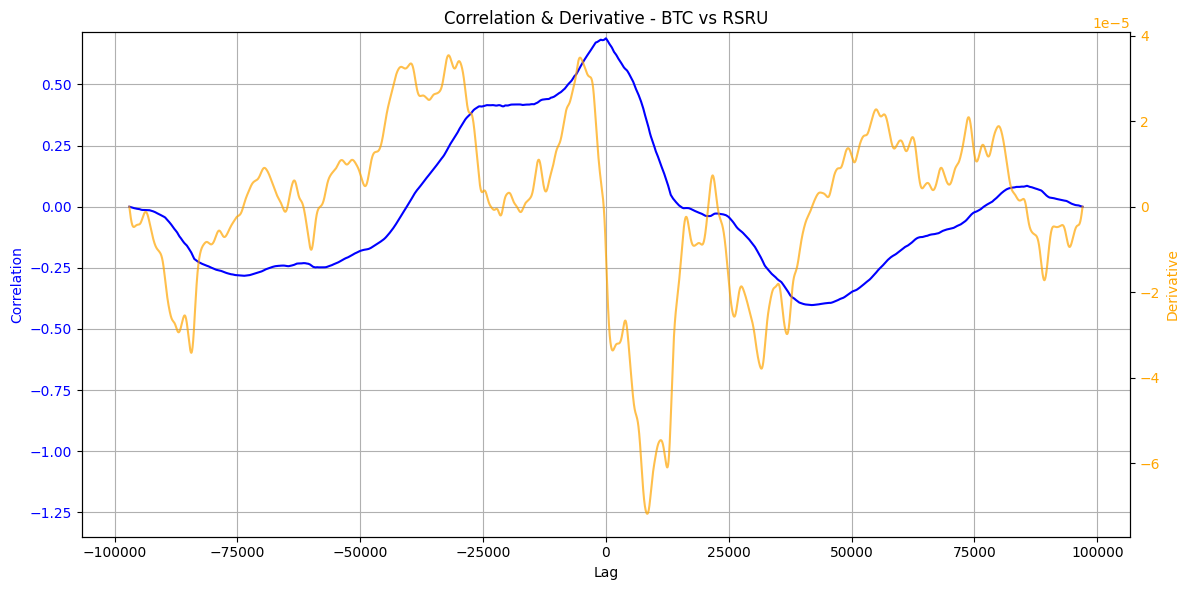

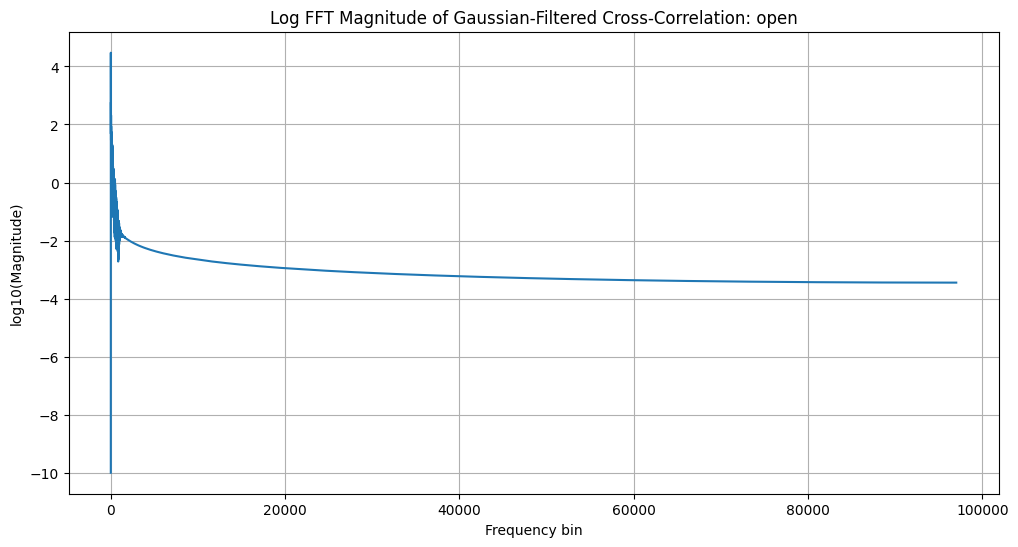

In [13]:
plot_correlation_and_derivative_dual_axis(data_dict["BTCUSDT"], data_dict["RSRUSDT"], column="open", title="BTC vs RSRU")
plot_filtered_cross_corr_fft(data_dict["BTCUSDT"], data_dict["RSRUSDT"], column="open",sigma=75)

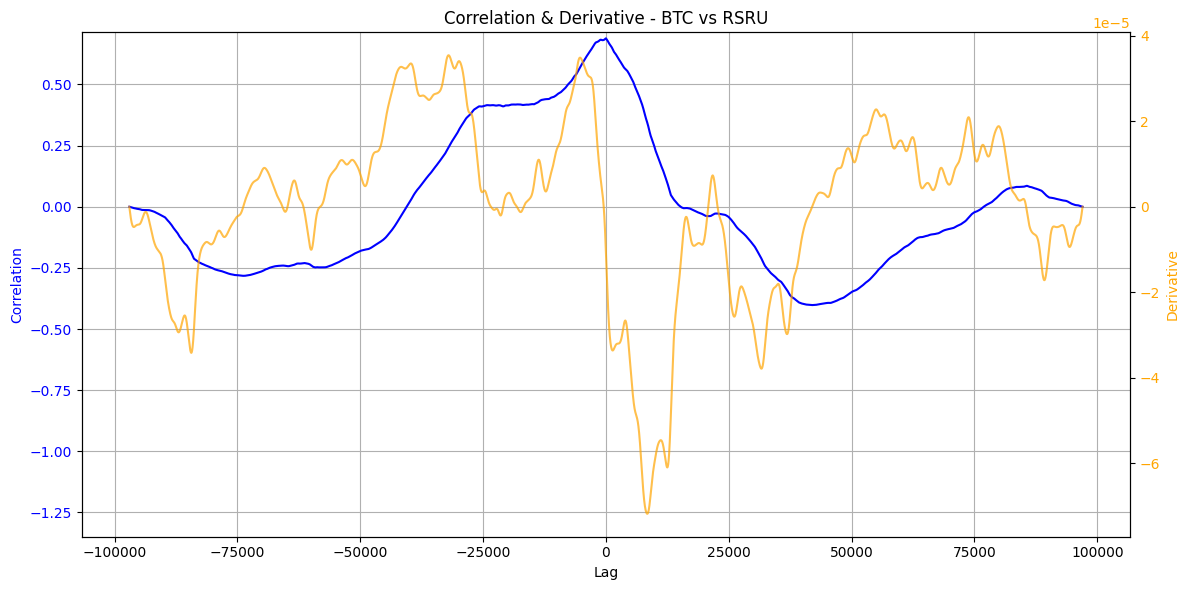

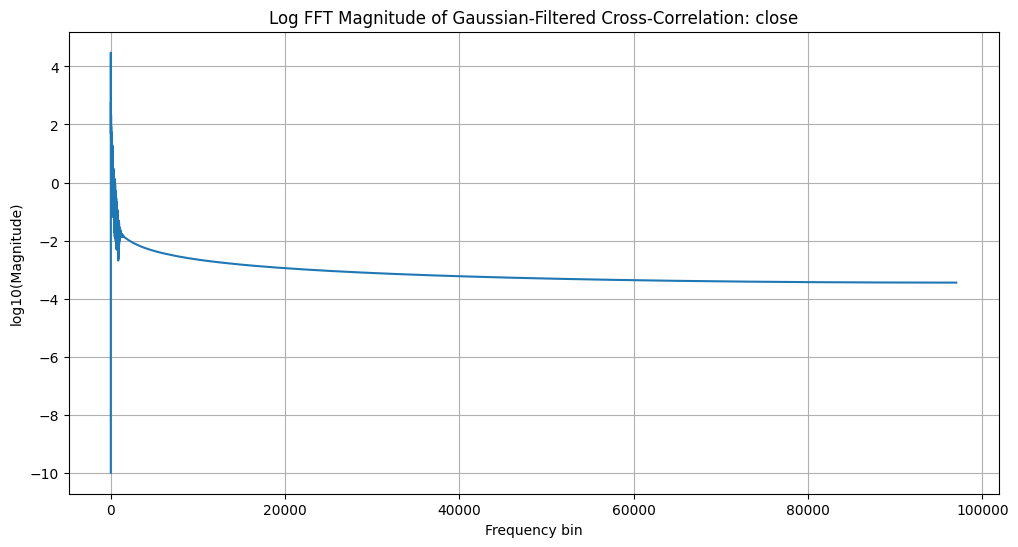

In [14]:
plot_correlation_and_derivative_dual_axis(data_dict["BTCUSDT"], data_dict["RSRUSDT"], column="close", title="BTC vs RSRU")
plot_filtered_cross_corr_fft(data_dict["BTCUSDT"], data_dict["RSRUSDT"], column="close",sigma=75)

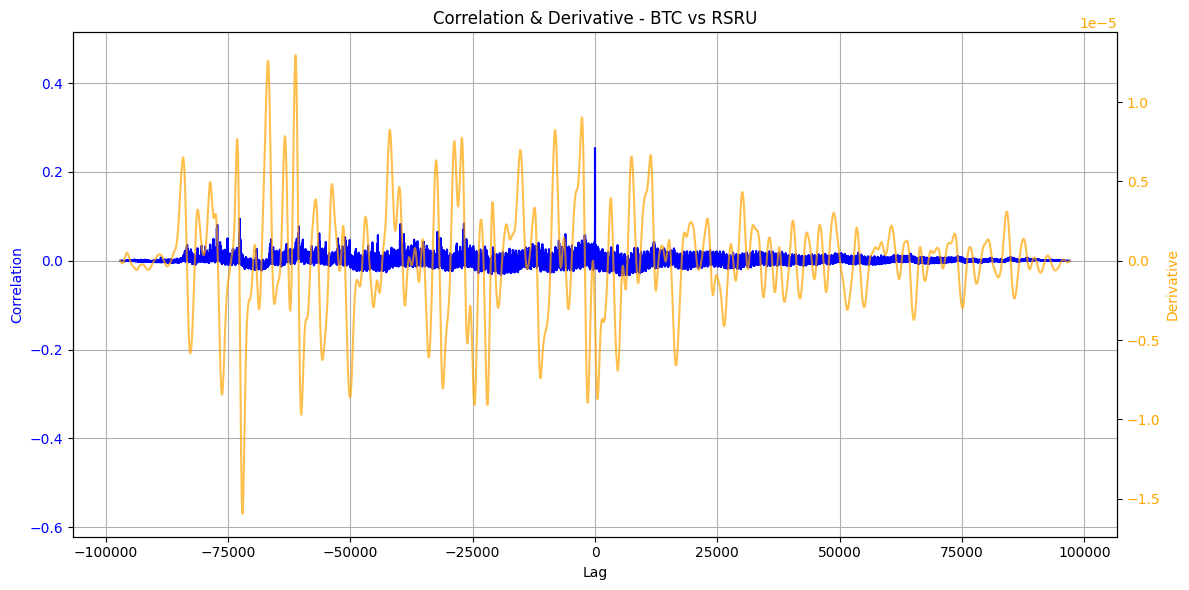

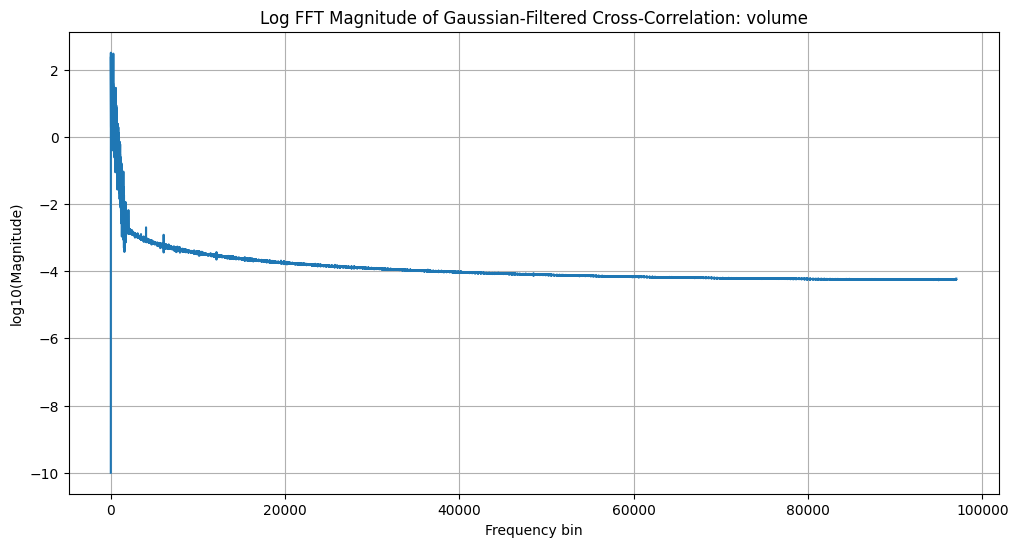

In [15]:
plot_correlation_and_derivative_dual_axis(data_dict["BTCUSDT"], data_dict["RSRUSDT"], column="volume", title="BTC vs RSRU")
plot_filtered_cross_corr_fft(data_dict["BTCUSDT"], data_dict["RSRUSDT"], column="volume",sigma=75)

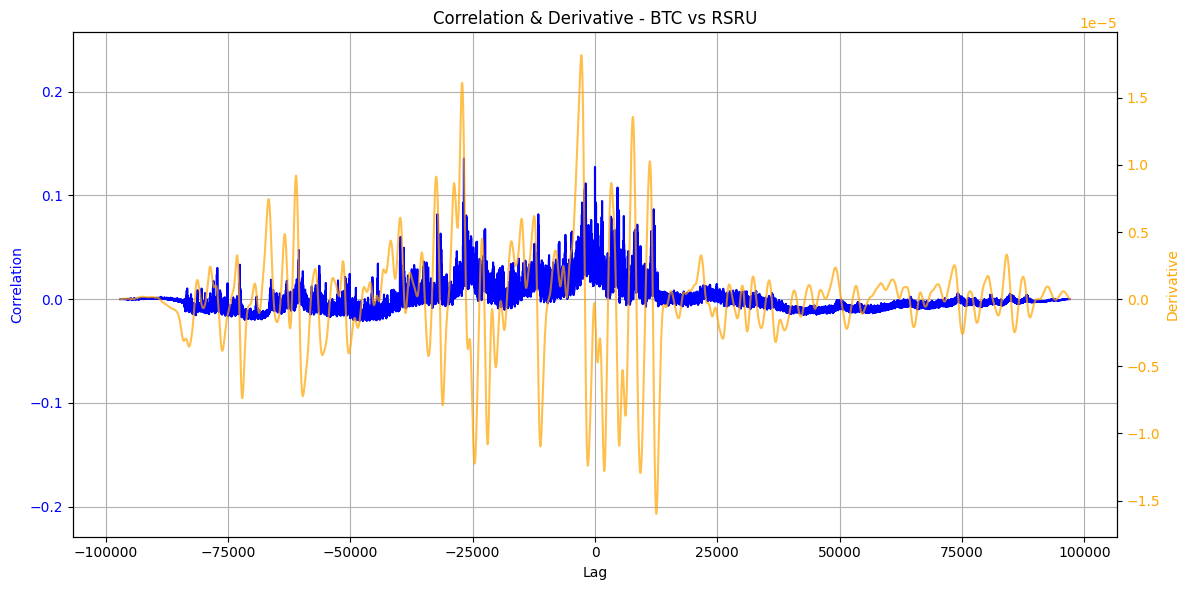

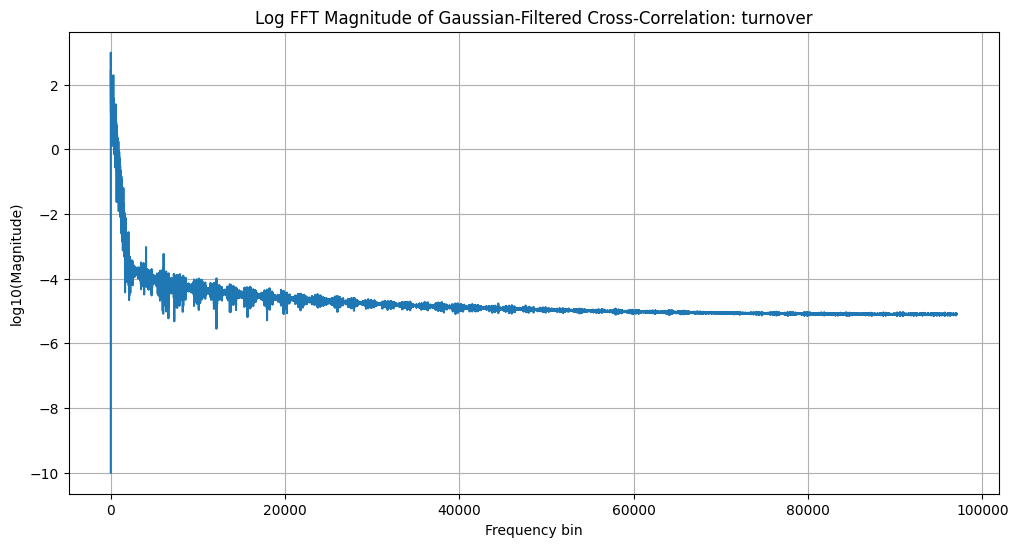

In [16]:
plot_correlation_and_derivative_dual_axis(data_dict["BTCUSDT"], data_dict["RSRUSDT"], column="turnover", title="BTC vs RSRU")
plot_filtered_cross_corr_fft(data_dict["BTCUSDT"], data_dict["RSRUSDT"], column="turnover",sigma=75)

In [17]:
features = ["open", "high", "low", "close"]
# features = ["open"]
matrices = build_feature_correlation_matrices(data_dict, features)

for feat, df in matrices.items():
    df.to_csv(f"correlation/correlation_matrix_{feat}.csv")


In [18]:
features = ["open", "high", "low", "close", "volume", "turnover"]
# features = ["open"]
matrices = build_fft_frequency_matrix(data_dict, features)

for feat, df in matrices.items():
    df.to_csv(f"fft/fft_matrix_{feat}.csv")